# CLAHE

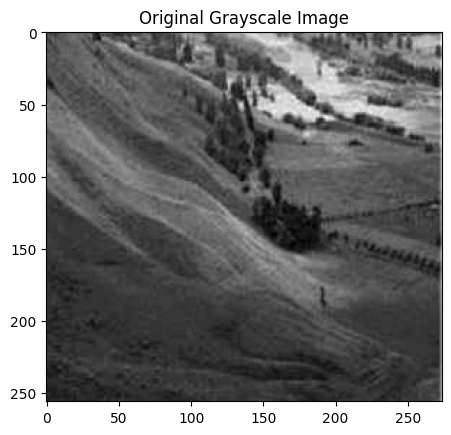

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('image1.jpg')

# Check if the image is loaded correctly
if image is None:
    raise ValueError("Image not found or path is incorrect")

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the original grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title('Original Grayscale Image')
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

#INTERPOLATION FUNCTION
def interpolate(subBin,LU,RU,LB,RB,subX,subY):
    subImage = np.zeros(subBin.shape)
    num = subX*subY
    for i in range(subX):
        inverseI = subX-i
        for j in range(subY):
            inverseJ = subY-j
            val = subBin[i,j].astype(int)
            subImage[i,j] = np.floor((inverseI*(inverseJ*LU[val] + j*RU[val])+ i*(inverseJ*LB[val] + j*RB[val]))/float(num))
    return subImage

#CLAHE FUNCTION
#ALL UTILITY FUNCTIONS COMBINED INTO ONE FUNCTION
def clahe(img,clipLimit,nrBins=128,nrX=0,nrY=0):
    '''img - Input image
       clipLimit - Normalized clipLimit. Higher value gives more contrast
       nrBins - Number of graylevel bins for histogram("dynamic range")
       nrX - Number of contextial regions in X direction
       nrY - Number of Contextial regions in Y direction'''
    h,w = img.shape
    if clipLimit==1:
        return
    nrBins = max(nrBins,128)
    if nrX==0:
        #Taking dimensions of each contextial region to be a square of 32X32
        xsz = 32
        ysz = 32
        nrX = np.ceil(h/xsz).astype(int)#240
        #Excess number of pixels to get an integer value of nrX and nrY
        excX= int(xsz*(nrX-h/xsz))
        nrY = np.ceil(w/ysz).astype(int)#320
        excY= int(ysz*(nrY-w/ysz))
        #Pad that number of pixels to the image
        if excX!=0:
            img = np.append(img,np.zeros((excX,img.shape[1])).astype(int),axis=0)
        if excY!=0:
            img = np.append(img,np.zeros((img.shape[0],excY)).astype(int),axis=1)
    else:
        xsz = round(h/nrX)
        ysz = round(w/nrY)

    nrPixels = xsz*ysz
    xsz2 = round(xsz/2)
    ysz2 = round(ysz/2)
    claheimg = np.zeros(img.shape)

    if clipLimit > 0:
        clipLimit = max(1,clipLimit*xsz*ysz/nrBins)
    else:
        clipLimit = 50

    #makeLUT
    print("...Make the LUT...")
    minVal = 0 #np.min(img)
    maxVal = 255 #np.max(img)

    #maxVal1 = maxVal + np.maximum(np.array([0]),minVal) - minVal
    #minVal1 = np.maximum(np.array([0]),minVal)

    binSz = np.floor(1+(maxVal-minVal)/float(nrBins))
    LUT = np.floor((np.arange(minVal,maxVal+1)-minVal)/float(binSz))

    #BACK TO CLAHE
    bins = LUT[img]
    print(bins.shape)
    #makeHistogram
    print("...Making the Histogram...")
    hist = np.zeros((nrX,nrY,nrBins))
    print(nrX,nrY,hist.shape)
    for i in range(nrX):
        for j in range(nrY):
            bin_ = bins[i*xsz:(i+1)*xsz,j*ysz:(j+1)*ysz].astype(int)
            for i1 in range(xsz):
                for j1 in range(ysz):
                    hist[i,j,bin_[i1,j1]]+=1

    #clipHistogram
    print("...Clipping the Histogram...")
    if clipLimit>0:
        for i in range(nrX):
            for j in range(nrY):
                nrExcess = 0
                for nr in range(nrBins):
                    excess = hist[i,j,nr] - clipLimit
                    if excess>0:
                        nrExcess += excess

                binIncr = nrExcess/nrBins
                upper = clipLimit - binIncr
                for nr in range(nrBins):
                    if hist[i,j,nr] > clipLimit:
                        hist[i,j,nr] = clipLimit
                    else:
                        if hist[i,j,nr]>upper:
                            nrExcess += upper - hist[i,j,nr]
                            hist[i,j,nr] = clipLimit
                        else:
                            nrExcess -= binIncr
                            hist[i,j,nr] += binIncr

                if nrExcess > 0:
                    stepSz = max(1,np.floor(1+nrExcess/nrBins))
                    for nr in range(nrBins):
                        nrExcess -= stepSz
                        hist[i,j,nr] += stepSz
                        if nrExcess < 1:
                            break

    #mapHistogram
    print("...Mapping the Histogram...")
    map_ = np.zeros((nrX,nrY,nrBins))
    #print(map_.shape)
    scale = (maxVal - minVal)/float(nrPixels)
    for i in range(nrX):
        for j in range(nrY):
            sum_ = 0
            for nr in range(nrBins):
                sum_ += hist[i,j,nr]
                map_[i,j,nr] = np.floor(min(minVal+sum_*scale,maxVal))

    print("...interpolation...")
    xI = 0
    for i in range(nrX+1):
        if i==0:
            subX = int(xsz/2)
            xU = 0
            xB = 0
        elif i==nrX:
            subX = int(xsz/2)
            xU = nrX-1
            xB = nrX-1
        else:
            subX = xsz
            xU = i-1
            xB = i

        yI = 0
        for j in range(nrY+1):
            if j==0:
                subY = int(ysz/2)
                yL = 0
                yR = 0
            elif j==nrY:
                subY = int(ysz/2)
                yL = nrY-1
                yR = nrY-1
            else:
                subY = ysz
                yL = j-1
                yR = j
            UL = map_[xU,yL,:]
            UR = map_[xU,yR,:]
            BL = map_[xB,yL,:]
            BR = map_[xB,yR,:]
            #print("CLAHE vals...")
            subBin = bins[xI:xI+subX,yI:yI+subY]
            #print("clahe subBin shape: ",subBin.shape)
            subImage = interpolate(subBin,UL,UR,BL,BR,subX,subY)
            claheimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX

    if excX==0 and excY!=0:
        return claheimg[:,:-excY]
    elif excX!=0 and excY==0:
        return claheimg[:-excX,:]
    elif excX!=0 and excY!=0:
        return claheimg[:-excX,:-excY]
    else:
        return claheimg

...Make the LUT...
(256, 288)
...Making the Histogram...
8 9 (8, 9, 128)
...Clipping the Histogram...
...Mapping the Histogram...
...interpolation...


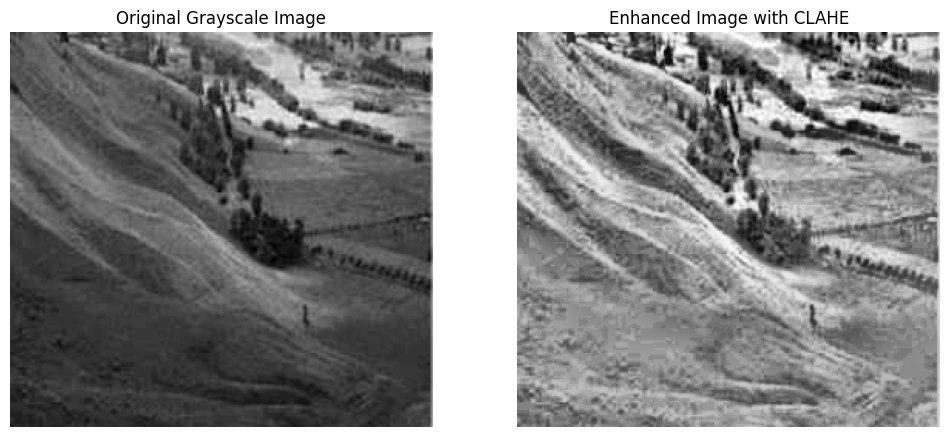

Original Contrast: 13.830674266620488
Enhanced Contrast: 45.548077622715816


In [34]:
# Apply CLAHE
clahe_img = clahe(gray_image, clipLimit=8, nrBins=128, nrX=0, nrY=0)

# Display the original and enhanced images side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(gray_image, cmap='gray')
axs[0].set_title('Original Grayscale Image')
axs[0].axis('off')

axs[1].imshow(clahe_img, cmap='gray')
axs[1].set_title('Enhanced Image with CLAHE')
axs[1].axis('off')

plt.show()

# Calculate and display contrast improvement
original_contrast = gray_image.std()
enhanced_contrast = clahe_img.std()

print(f'Original Contrast: {original_contrast}')
print(f'Enhanced Contrast: {enhanced_contrast}')

# Restoration

### In this exercise we aim to compare wiener and inverse filters while image is blurred and noisy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import math
import cv2

### In the first step read `sample.jpg` image then use `motion_process()` and `make_blurred()` functions to apply a motion blur on input image.

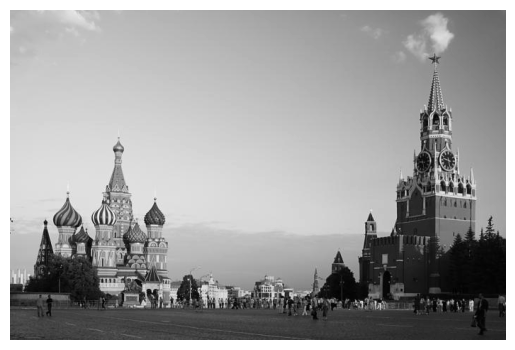

In [10]:
sample_img = plt.imread('sample.jpg')
sample_img_gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
plt.imshow(sample_img_gray, cmap='gray')
plt.axis(False)
plt.show()

In [18]:
sample_img_gray_norm = sample_img_gray / 255.

In [53]:
# Simulated motion blur
def motion_process(image_size, motion_angle=60, debug: bool=False):
    """
    image_size: a tuple(image_height, image_width)
    """
    PSF = np.zeros(image_size)
    center_position = (image_size[0] - 1) / 2

    slope_tan = math.tan(motion_angle * math.pi / 180)
    slope_cot = 1 / slope_tan

    if debug:
        print(f'{slope_tan=}')
        print(f'{slope_cot=}')

    if slope_tan <= 1:
        for i in range(15):
            offset = round(i * slope_tan)  # ((center_position-i)*slope_tan)
            PSF[int(center_position + offset), int(center_position - offset)] = 1

    else:
        for i in range(15):
            offset = round(i * slope_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1

    normalized_PSF = PSF / PSF.sum()  # Normalize the luminance of the point spread function
    if debug:
        plt.imshow(normalized_PSF, cmap='gray')
        plt.show()

    return normalized_PSF

# Blur the image with motion
def make_blurred(input, PSF, eps=1e-3, debug: bool=False):
    """
    input: original image
    PSF: point spread function (PSF) describes the response of a focused optical imaging system
         to a point source or point object. i.e. it is output of motion_process() function.
    """
    input_fft = fft.fft2(input)  # Take the Fourier transform of a two-dimensional array
    PSF_fft = fft.fft2(PSF) + eps
    blurred_fft = input_fft * PSF_fft
    blurred = np.abs(fft.fftshift((fft.ifft2(blurred_fft))))
    blureed = np.clip(blurred, 0, 255)

    if debug:
        plt.figure(figsize=(6, 8))

        plt.subplot(3, 2, 1)
        plt.imshow(input, cmap='gray')
        plt.title('Original Input')
        plt.axis(False)

        plt.subplot(3, 2, 2)
        plt.imshow(np.abs(np.log(input_fft)), cmap='gray')
        plt.title(r'$\mathcal{F}$(Input)')
        plt.axis(False)

        plt.subplot(3, 2, 3)
        plt.imshow(PSF, cmap='gray')
        plt.title('Point Spread Function')
        plt.axis(False)

        plt.subplot(3, 2, 4)
        plt.imshow(np.abs(np.log(PSF_fft)), cmap='gray')
        plt.title(r'$\mathcal{F}$(PSF)')
        plt.axis(False)

        plt.subplot(3, 2, 5)
        plt.imshow(blurred, cmap='gray')
        plt.title("Blurred Output")
        plt.axis(False)

        plt.subplot(3, 2, 6)
        plt.imshow(np.abs(np.log(blurred_fft)), cmap='gray')
        plt.title(r'$\mathcal{F}$(Blurred)')
        plt.axis(False)

    return blurred

slope_tan=1.7320508075688767
slope_cot=0.577350269189626


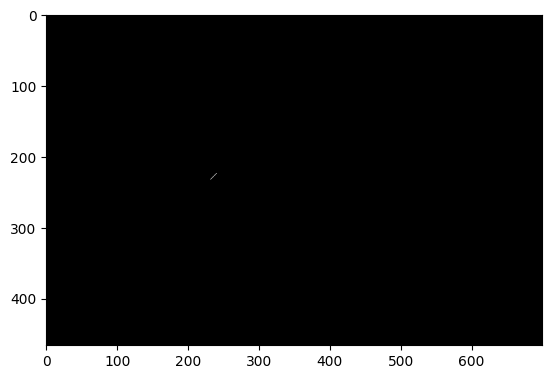

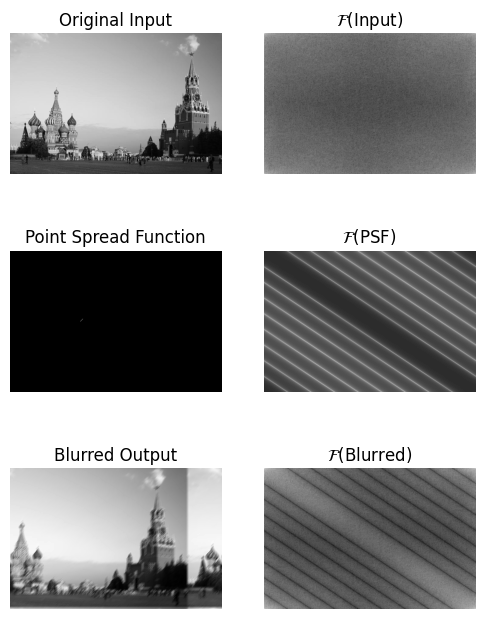

In [54]:
# TODO: read input image. Then show both original and motion blurred image.
h, w, c = sample_img.shape
PSF = motion_process((h, w), debug=True)
blurred_sample_img = make_blurred(sample_img_gray, PSF, debug=True)

### In the second step write two functions for wiener and inverse filters. Then use them to restore blurred image. At last show the outputs.

In [55]:
def inverse_filter(degraded_img, H):
    # Perform Fourier transform of the degraded image
    F_uv = np.fft.fft2(degraded_img)
    F_uv_shifted = np.fft.fftshift(F_uv)

    # Perform inverse filtering
    H_fft = np.fft.fft2(H)
    H_fft_shifted = np.fft.fftshift(H_fft)
    G_uv = F_uv_shifted / H_fft_shifted

    # Inverse Fourier transform to get the restored image
    G_uv_shifted = np.fft.ifftshift(G_uv)
    restored_img = np.fft.ifft2(G_uv)
    restored_img = np.fft.fftshift(restored_img)
    restored_img = np.abs(restored_img)

    return restored_img


def wiener_filter(degraded_img, H, K):
    # Perform Fourier transform of the degraded image
    F_uv = np.fft.fft2(degraded_img)
    F_uv_shifted = np.fft.fftshift(F_uv)

    # Perform Wiener filtering
    H_fft = np.fft.fft2(H)
    H_fft_shifted = np.fft.fftshift(H_fft)
    H_conjugate = np.conj(H_fft_shifted)
    denominator = np.abs(H_fft_shifted)**2 + K
    G_uv = (H_conjugate / denominator) * F_uv_shifted

    # Inverse Fourier transform to get the restored image
    G_uv_shifted = np.fft.ifftshift(G_uv)
    restored_img = np.fft.ifft2(G_uv_shifted)
    restored_img = np.fft.fftshift(restored_img)
    restored_img = np.abs(restored_img)

    return restored_img

### In the last step write a function to calculate PSNR between two images. Use this function to compare all previous steps results with original image.

In [51]:
def calculate_psnr(img1, img2):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Parameters:
    img1 (numpy.ndarray): The original image.
    img2 (numpy.ndarray): The reconstructed or processed image.

    Returns:
    float: The PSNR value in decibels.
    """
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
# TODO: compare all results with original image.

# I added PSNR to the title of restored images

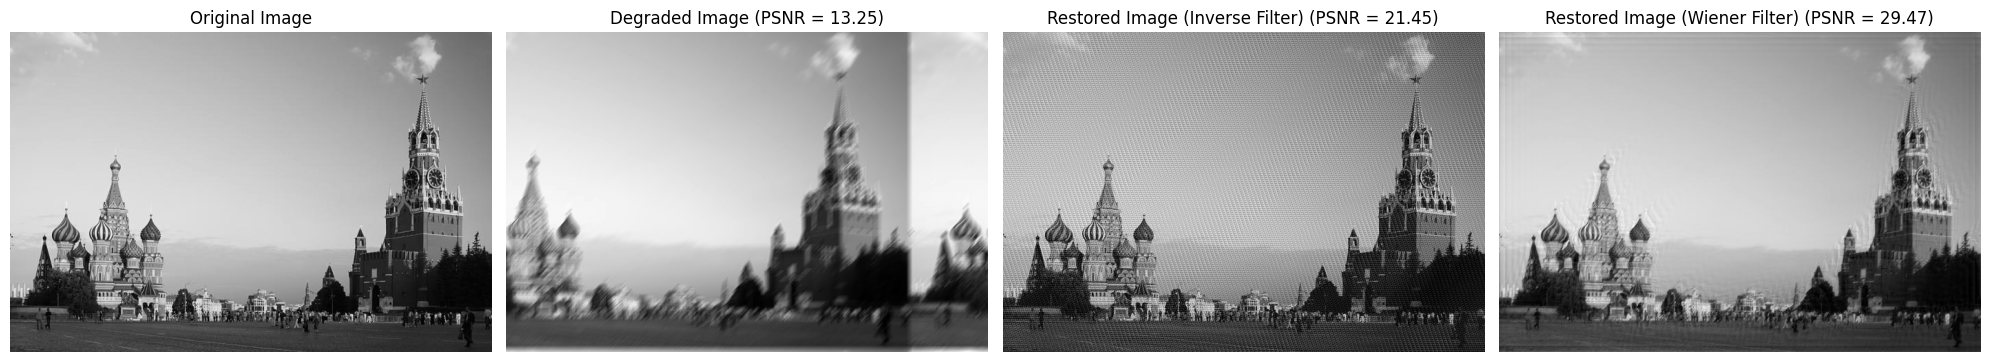

In [60]:
# TODO: show the results of restored degraded images, by filters.
K = 0.01  # Example value for K, adjust as necessary

# Apply inverse filter
restored_img_inverse = inverse_filter(blurred_sample_img, PSF)

# Apply Wiener filter
restored_img_wiener = wiener_filter(blurred_sample_img, PSF, K)

# Plot the original, degraded, and restored images
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(sample_img_gray, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(blurred_sample_img, cmap='gray')
axs[1].set_title(f'Degraded Image (PSNR = {calculate_psnr(sample_img_gray, blurred_sample_img):.2f})')
axs[1].axis('off')

axs[2].imshow(restored_img_inverse, cmap='gray')
axs[2].set_title(f'Restored Image (Inverse Filter) (PSNR = {calculate_psnr(sample_img_gray, restored_img_inverse):.2f})')
axs[2].axis('off')

axs[3].imshow(restored_img_wiener, cmap='gray')
axs[3].set_title(f'Restored Image (Wiener Filter) (PSNR = {calculate_psnr(sample_img_gray, restored_img_wiener):.2f})')
axs[3].axis('off')

plt.tight_layout()
plt.show()

### Now use `add_noise()` function to add noise on blurred image. Show blurred and noisy image then use your wiener and inverse filters to restore this image. Show the outputs.

In [58]:
def add_noise(blurred_image):
    blurred_noisy_img = (
        blurred_image
        + 0.1 * blurred_image.std() * np.random.standard_normal(blurred_image.shape)
    )

    return blurred_noisy_img

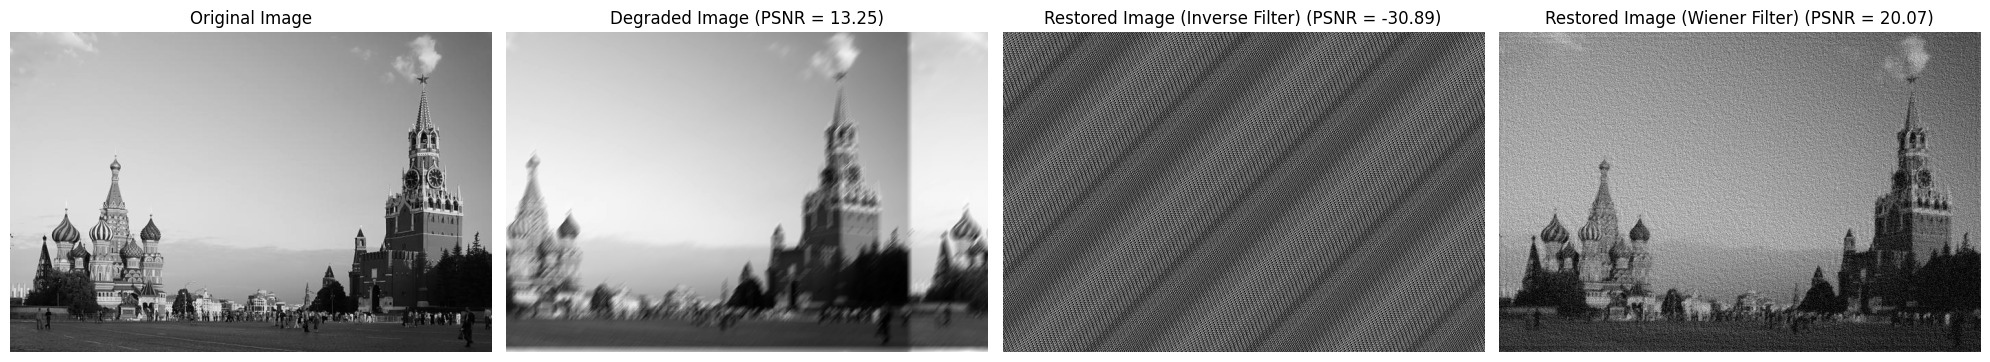

In [61]:
# TODO: apply filters on blurred and noisy image to restore it. Then show the results.
K = 0.01  # Example value for K, adjust as necessary

blurred_sample_img_noisy = add_noise(blurred_sample_img)

# Apply inverse filter
restored_img_inverse = inverse_filter(blurred_sample_img_noisy, PSF)

# Apply Wiener filter
restored_img_wiener = wiener_filter(blurred_sample_img_noisy, PSF, K)

# Plot the original, degraded, and restored images
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(sample_img_gray_norm, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(blurred_sample_img, cmap='gray')
axs[1].set_title(f'Degraded Image (PSNR = {calculate_psnr(sample_img_gray, blurred_sample_img):.2f})')
axs[1].axis('off')

axs[2].imshow(restored_img_inverse, cmap='gray')
axs[2].set_title(f'Restored Image (Inverse Filter) (PSNR = {calculate_psnr(sample_img_gray, restored_img_inverse):.2f})')
axs[2].axis('off')

axs[3].imshow(restored_img_wiener, cmap='gray')
axs[3].set_title(f'Restored Image (Wiener Filter) (PSNR = {calculate_psnr(sample_img_gray, restored_img_wiener):.2f})')
axs[3].axis('off')

plt.tight_layout()
plt.show()

### Compare the results of previous step. Which one of the filters worked better after noise addition ?

your answer:
In noisy conditions, we observe that Wiener Filter outperforms the Inverse Filter. That's mainly due to considering noise in the model formulation of the image degradation that make Wiener Filter suitable for this kind of degradations.